<a href="https://colab.research.google.com/github/jennahgosciak/nyc_fire_risk/blob/main/00_data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
# setup
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import requests
import calendar
import geopandas as gpd
import os.path as os
import scipy.stats
import seaborn.palettes
import seaborn.utils
import sys
from census import Census
from us import states
import http.client, urllib.request, urllib.parse, urllib.error, base64
import config

In [86]:
# load sklearn modules
import sklearn
from sklearn import linear_model, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

In [87]:
root= r"C:/Users/Jennah/Desktop/Code/nyc_fire_risk"

# Data Prep
* Load analysis data, created in 00_data_processing.ipynb

In [88]:
df= pd.read_csv(os.join(root, "data/analysis_file.csv"), index_col = 0)
df.head()

nacols= df.columns[df.isna().any()]
# use 0 imputation
df[[x + "_na" for x in nacols]] = df[nacols].apply(lambda x: np.where(
                                        x.isna() | np.isinf(x), 1, 0))
df[[x + "_na" for x in nacols]]
df[nacols]= df[nacols].apply(lambda x: np.where(
                    x.isna() | np.isinf(x), 1, 0))

assert all([(df.loc[(df[nacols[i]] == 0), nacols[i]+"_na"] == 0).all() for i in range(len(nacols))])

# Logistic Regression

In [89]:
# set x and y and split data for test/train
X= df.loc[:, df.columns[df.columns != "vacate_ind"]]
y= df.loc[:, "vacate_ind"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 999)
# apply logistic regression
lm=linear_model.LinearRegression()
lm.fit(X_train,y_train)

print("\nScore with logistic regression:", lm.score(X_test, y_test))


Score with logistic regression: 0.10623105135275401


# Decision Tree Models

In [90]:
from sklearn.tree import DecisionTreeClassifier

# learn model
dt=DecisionTreeClassifier()
dt.fit(X_train,y_train)
dt.score(X_test, y_test)

0.9966128413787226

In [91]:
# what is average w different random states
OS=[]
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = i)    
    dt = DecisionTreeClassifier()
    dt.fit(X_train,y_train)
    OS.append(dt.score(X_test,y_test))
print(np.mean(OS))

0.996487509408774


In [93]:
# what is average w same random states, but different max depth values
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.3,random_state=999)

depths = range(1, 20)
OS= []
APS= []
for i in depths:
    dt = DecisionTreeClassifier(random_state = 999, max_depth = i)
    dt.fit(X_train,y_train)
    # use both score and average precision score
    OS.append(dt.score(X_test,y_test))
    pred=dt.predict_proba(X_test)[:,1]
    APS.append(average_precision_score(np.array(y_test),pred))
    
print("Out of sample score:", np.mean(OS))
print("Average precision score:", np.mean(APS))

Out of sample score: 0.9959397449783121
Average precision score: 0.3145432348411598


**Since the data is unbalanced, it makes sense to use the precision recall curve**

Also, we are more interested in a positive outcome (e.g., a fire vacate order) than a negative outcome
* Precision: what proportion of positive identifications was actually correct?
* Recall: what proportion of actual positives was identified correctly?

In [94]:
# what about using precision-recall area under the curve instead of the score
APS=[]
for i in range(10):
    X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.3, random_state=i)
    dt=DecisionTreeClassifier()
    dt.fit(X_train,y_train)
    # probability of each class for each record
    pred=dt.predict_proba(X_test)[:,1] # predicted probability of y = 1
    APS.append(average_precision_score(np.array(y_test),pred))
print("Out of sample average precision score",np.mean(APS))

Out of sample average precision score 0.39511221167644067


In [95]:
# random chance
chance_OS=[]
for i in range(10):
    X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.3, random_state=i)
    # create 'prediction' vector that's the length of X_test vector
    pred=np.random.random(len(X_test))
    chance_OS.append(average_precision_score(np.array(y_test.apply(int)),pred))
print("Random chance", np.mean(chance_OS))

Random chance 0.004725719373384211


**Test different hyper-parameters, such as maximum depth**

In [98]:
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.3, random_state=999)

# what about using precision-recall area under the curve instead of the score
APS=[]
for i in range(1, 21):
    dt=DecisionTreeClassifier(random_state = 999, max_depth = i)
    dt.fit(X_train,y_train)
    # probability of each class for each record
    pred=dt.predict_proba(X_test)[:,1] # predicted probability of y = 1
    APS.append(average_precision_score(np.array(y_test),pred))

Out of sample average precision score 0.3224826930823945


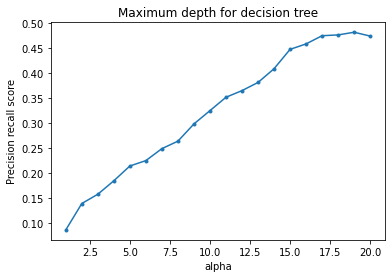

In [101]:
ax = plt.gca()
ax.plot(range(1, 21), APS, '.-')
plt.xlabel('alpha')
plt.ylabel('Precision recall score')
plt.title('Maximum depth for decision tree')
plt.axis('tight')
plt.show()

**Tuning with gridsearchcv**

In [106]:
from sklearn.model_selection import GridSearchCV
param_grid ={'max_depth': np.arange(1, 51, 2)}

dt=DecisionTreeClassifier(random_state = 999)
gr=GridSearchCV(dt,param_grid=param_grid, cv=5, scoring = "recall")
rs=gr.fit(X_train,y_train)
pred=rs.predict_proba(X_test)[:,1]
print(average_precision_score(np.array(y_test),pred))
print(rs.best_params_)

0.34403241644763743
{'max_depth': 41}


# Ensemble Methods: Random Forests